<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/AI_LSTM/LSTM_ptemp_max_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Develop 1

## 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/

Mounted at /content/drive/
/content/drive/MyDrive/LoadForecasting


## 체감온도만 반영해서 max값 예측하는 코드

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# 2023년 데이터는 test set으로 사용
test_set = df[df['date'].dt.year == 2023]

# 2023년 데이터를 제외한 나머지 데이터로 train과 validation 세트를 나눔
train_validation_set = df[df['date'].dt.year != 2023]

# train_validation_set을 train과 validation으로 랜덤하게 나눔
train_set, validation_set = train_test_split(train_validation_set, test_size=0.2, random_state=42)

# 결과 확인
print("Train set 크기:", len(train_set))
print("Validation set 크기:", len(validation_set))
print("Test set 크기:", len(test_set))

# 필요한 열 선택
data = df[['p-temp', 'max']]

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], 1)),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X, y, epochs=50, batch_size=32, verbose=0)

# 예측 함수
def predict_max_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0]

    # 해당 날짜의 p-temp 값 추출
    p_temp = df.loc[idx, 'p-temp']

    # 이전 sequence_length일의 p-temp 값 추출
    X_input = data_scaled[idx-sequence_length:idx, 0]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, 1))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    predicted_max = scaler.inverse_transform([[X_input[0][-1][0], prediction[0][0]]])[0][1]

    return predicted_max, p_temp

# 2023년 1월 1일부터 2023년 12월 31일까지 예측값, 실제값, p-temp 및 오차율 출력
print("날짜\t\tp-temp\t\t예상 최고 전력값\t실제 최고 전력값\t오차율")
print("---------------------------------------------------------")
errors = []
for date in pd.date_range(start='2023-01-01', end='2023-12-31'):
    date_str = date.strftime('%Y-%m-%d')
    predicted_max, p_temp = predict_max_for_date(date_str, model, scaler, sequence_length)
    actual_max = df[df['date'] == date_str]['max'].values[0]
    error = abs(predicted_max - actual_max)
    error_rate = (error / actual_max) * 100
    errors.append(error_rate)
    print(f"{date_str}\t{p_temp:.2f}\t\t{predicted_max:.2f}\t\t{actual_max}\t\t{error_rate:.2f}%")

# 평균 오차율과 분산 계산
mean_error = np.mean(errors)
variance_error = np.std(errors)

print(f"\n평균 오차율: {mean_error:.2f}%")
print(f"오차율의 표준편차: {variance_error:.2f}")

Train set 크기: 584
Validation set 크기: 146
Test set 크기: 365
날짜		p-temp		예상 최고 전력값	실제 최고 전력값	오차율
---------------------------------------------------------
1/1 [==============================] - 0s 417ms/step
2023-01-01	2.60		907.64		859		5.66%
1/1 [==============================] - 0s 23ms/step
2023-01-02	-0.50		902.72		989		8.72%
1/1 [==============================] - 0s 23ms/step
2023-01-03	0.50		909.30		976		6.83%
1/1 [==============================] - 0s 25ms/step
2023-01-04	1.30		909.40		963		5.57%
1/1 [==============================] - 0s 21ms/step
2023-01-05	1.80		907.25		943		3.79%
1/1 [==============================] - 0s 20ms/step
2023-01-06	3.10		904.34		912		0.84%
1/1 [==============================] - 0s 20ms/step
2023-01-07	3.50		898.04		935		3.95%
1/1 [==============================] - 0s 23ms/step
2023-01-08	0.80		892.33		891		0.15%
1/1 [==============================] - 0s 28ms/step
2023-01-09	4.30		897.26		908		1.18%
1/1 [==============================] - 0s 20ms/step
20

:## 체감온도만 반영해서 min값 예측하는 코드

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# 2023년 데이터는 test set으로 사용
test_set = df[df['date'].dt.year == 2023]

# 2023년 데이터를 제외한 나머지 데이터로 train과 validation 세트를 나눔
train_validation_set = df[df['date'].dt.year != 2023]

# train_validation_set을 train과 validation으로 랜덤하게 나눔
train_set, validation_set = train_test_split(train_validation_set, test_size=0.1, random_state=42)

# 결과 확인
print("Train set 크기:", len(train_set))
print("Validation set 크기:", len(validation_set))
print("Test set 크기:", len(test_set))

# 필요한 열 선택
data = df[['p-temp', 'min']]

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 50  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)
print(X.shape)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], 1)),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X, y, epochs=50, batch_size=32, verbose=0)

# 예측 함수
def predict_min_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0]

    # 해당 날짜의 p-temp 값 추출
    p_temp = df.loc[idx, 'p-temp']

    # 이전 sequence_length일의 p-temp 값 추출
    X_input = data_scaled[idx-sequence_length:idx, 0]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, 1))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    predicted_min = scaler.inverse_transform([[X_input[0][-1][0], prediction[0][0]]])[0][1]

    return predicted_min, p_temp

# 2023년 1월 1일부터 2023년 12월 31일까지 예측값, 실제값, p-temp 및 오차율 출력
print("날짜\t\tp-temp\t\t예상 최저 전력값\t실제 최저 전력값\t오차율")
print("---------------------------------------------------------")
errors = []
for date in pd.date_range(start='2023-01-01', end='2023-12-31'):
    date_str = date.strftime('%Y-%m-%d')
    predicted_min, p_temp = predict_min_for_date(date_str, model, scaler, sequence_length)
    actual_min = df[df['date'] == date_str]['min'].values[0]
    error = abs(predicted_min - actual_min)
    error_rate = (error / actual_min) * 100
    errors.append(error_rate)
    print(f"{date_str}\t{p_temp:.2f}\t\t{predicted_min:.2f}\t\t{actual_min}\t\t{error_rate:.2f}%")

# 평균 오차율과 분산 계산
mean_error = np.mean(errors)
variance_error = np.var(errors)

print(f"\n평균 오차율: {mean_error:.2f}%")
print(f"오차율의 분산: {variance_error:.2f}")

Train set 크기: 657
Validation set 크기: 73
Test set 크기: 365
(1045, 50)
날짜		p-temp		예상 최저 전력값	실제 최저 전력값	오차율
---------------------------------------------------------
1/1 [==============================] - 0s 426ms/step
2023-01-01	2.60		658.37		566		16.32%
1/1 [==============================] - 0s 133ms/step
2023-01-02	-0.50		654.24		651		0.50%
1/1 [==============================] - 0s 21ms/step
2023-01-03	0.50		659.95		687		3.94%
1/1 [==============================] - 0s 27ms/step
2023-01-04	1.30		659.77		616		7.11%
1/1 [==============================] - 0s 20ms/step
2023-01-05	1.80		657.21		650		1.11%
1/1 [==============================] - 0s 39ms/step
2023-01-06	3.10		653.62		729		10.34%
1/1 [==============================] - 0s 20ms/step
2023-01-07	3.50		646.60		551		17.35%
1/1 [==============================] - 0s 22ms/step
2023-01-08	0.80		639.62		515		24.20%
1/1 [==============================] - 0s 32ms/step
2023-01-09	4.30		640.64		629		1.85%
1/1 [==============================] - 

## 외생변수 추가
외생변수 별 가중치 임의 산정 및 적용 테스트 <br/>
시간대별 예측 모델 개발을 위해 1차적으로 19시 데이터를 예측해봄.

Train set 크기: 657
Validation set 크기: 73
Test set 크기: 365


<ipython-input-4-e542079668c1>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


Epoch 1/10
27/27 [==============================] - 3s 46ms/step - loss: 0.0485 - val_loss: 0.0264
Epoch 2/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0215 - val_loss: 0.0246
Epoch 3/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0179 - val_loss: 0.0199
Epoch 4/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.0170
Epoch 5/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0125 - val_loss: 0.0163
Epoch 6/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0184
Epoch 7/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0123 - val_loss: 0.0279
Epoch 8/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0186
Epoch 9/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0341
Epoch 10/10
27/27 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 0.0148


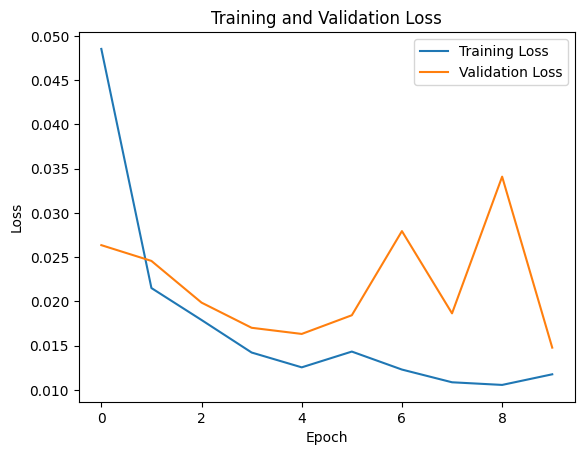


날짜		예상 최고 전력값	실제 최고 전력값	오차율
---------------------------------------------------------
1/1 [==============================] - 0s 421ms/step
2023-01-01	937.59		859		9.15%
1/1 [==============================] - 0s 21ms/step
2023-01-02	940.58		989		-4.90%
1/1 [==============================] - 0s 21ms/step
2023-01-03	965.17		976		-1.11%
1/1 [==============================] - 0s 23ms/step
2023-01-04	957.18		963		-0.60%
1/1 [==============================] - 0s 32ms/step
2023-01-05	911.77		943		-3.31%
1/1 [==============================] - 0s 22ms/step
2023-01-06	910.06		912		-0.21%
1/1 [==============================] - 0s 20ms/step
2023-01-07	916.28		934		-1.90%
1/1 [==============================] - 0s 20ms/step
2023-01-08	913.15		881		3.65%
1/1 [==============================] - 0s 24ms/step
2023-01-09	876.67		908		-3.45%
1/1 [==============================] - 0s 21ms/step
2023-01-10	885.88		900		-1.57%
1/1 [==============================] - 0s 20ms/step
2023-01-11	886.08		902		-1.76%
1

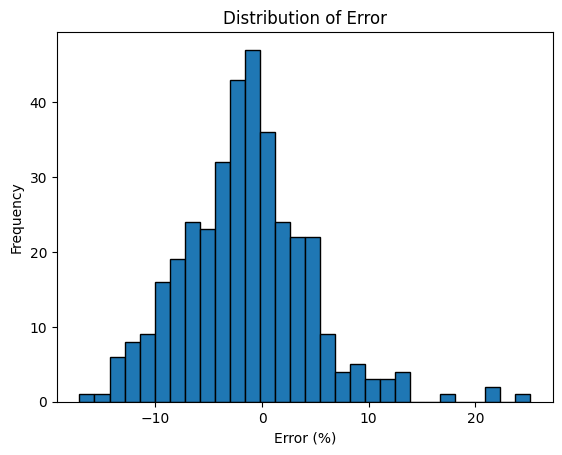

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# 2023년 데이터는 test set으로 사용
test_set = df[df['date'].dt.year == 2023]

# 2023년 데이터를 제외한 나머지 데이터로 train과 validation 세트를 나눔
train_validation_set = df[df['date'].dt.year != 2023]

# train_validation_set을 train과 validation으로 랜덤하게 나눔
train_set, validation_set = train_test_split(train_validation_set, test_size=0.1, random_state=42)

# 결과 확인
print("Train set 크기:", len(train_set))
print("Validation set 크기:", len(validation_set))
print("Test set 크기:", len(test_set))

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# 외생변수 추가: rain과 wind
data = df[['p-temp', 'solar', 'cloud', 'rain', 'wind', 'TIME_19']]

# 변수별 가중치 설정
weight_p_temp = 20.0  # p-temp 변수에 대한 가중치
weight_solar = 1.0  # solar 변수에 대한 가중치
weight_cloud = 1.0  # cloud 변수에 대한 가중치
weight_rain = 10.0  # rain 변수에 대한 가중치
weight_wind = 15.0  # wind 변수에 대한 가중치

# 빈 셀을 0으로 채움
data.fillna(0, inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1] * [weight_p_temp, weight_solar, weight_cloud, weight_rain, weight_wind])  # 'max' 열을 제외한 나머지 열 선택 후 가중치 적용
        y.append(data[i+seq_length, -1])  # 'max' 열만 선택
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X, y, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 예측 함수
def predict_max_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0]

    # 이전 sequence_length일의 데이터 추출 및 변수별 가중치 적용
    X_input = data_scaled[idx-sequence_length:idx, :-1] * [weight_p_temp, weight_solar, weight_cloud, weight_rain, weight_wind]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, X_input.shape[1]))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    predicted_max = scaler.inverse_transform([[X_input[0][-1][0], X_input[0][-1][1], X_input[0][-1][2], X_input[0][-1][3], X_input[0][-1][4], prediction[0][0]]])[0][-1]

    return predicted_max

# 2023년 1월 1일부터 2023년 12월 31일까지 예측값, 실제값 및 오차율 출력
print("\n날짜\t\t예상 최고 전력값\t실제 최고 전력값\t오차율")
print("---------------------------------------------------------")
errors = []
errors_abs = []
for date in pd.date_range(start='2023-01-01', end='2023-12-31'):
    date_str = date.strftime('%Y-%m-%d')
    predicted_max = predict_max_for_date(date_str, model, scaler, sequence_length)
    actual_max = df[df['date'] == date_str]['TIME_19'].values[0]
    error = predicted_max - actual_max
    err_abs = abs(error)
    error_rate = (error / actual_max) * 100
    err_abs_rate = (err_abs / actual_max) * 100
    errors.append(error_rate)
    errors_abs.append(err_abs_rate)
    print(f"{date_str}\t{predicted_max:.2f}\t\t{actual_max}\t\t{error_rate:.2f}%")

# 평균 오차율과 분산 계산
mean_error = np.mean(errors_abs)
variance_error = np.var(errors_abs)

print(f"\n평균 오차율: {mean_error:.2f}%")
print(f"오차율의 분산: {variance_error:.2f}")

# 평균 오차율의 분포도 그래프 출력
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Error')
plt.show()